#### Load and process data

In [1]:
using QuantumACES, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
default(grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    legendfonthalign=:left, foreground_color=:black,
    background_color=:transparent, background_color_outside=:transparent,
    tex_output_standalone=true,
)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
ls_type = :wls
budget_set = [10^6; 10^7; 10^8]
rotated_param = get_rotated_param(dist)
dep_param = get_dep_param(r_1, r_2, r_m)
log_param = get_log_param(r_1, r_2, r_m, total_std_log; seed=seed)
rotated_planar = get_circuit(rotated_param, dep_param)
# Load the metadata
metadata_dict = load("data/design_metadata_$(rotated_param.circuit_name).jld2")
@assert rotated_param == metadata_dict["rotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
gls_tuple_number = metadata_dict["gls_tuple_number"]
gls_repeat_numbers = metadata_dict["gls_repeat_numbers"]
ols_tuple_number = metadata_dict["ols_tuple_number"]
ols_repeat_numbers = metadata_dict["ols_repeat_numbers"]
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
tuple_number = tuple_number_set[dep_idx]
repeat_numbers = repeat_numbers_set[dep_idx]
basic_tuple_number = length(get_basic_tuple_set(rotated_planar))
basic_repeat_numbers = Int[]
# Load the data
aces_data_dep = load_aces(rotated_param, dep_param, tuple_number, repeat_numbers, true, ls_type, budget_set)
aces_data_log = load_aces(rotated_param, log_param, tuple_number, repeat_numbers, true, ls_type, budget_set)
aces_data_basic_dep = load_aces(rotated_param, dep_param, basic_tuple_number, basic_repeat_numbers, true, :none, budget_set)
aces_data_basic_log = load_aces(rotated_param, log_param, basic_tuple_number, basic_repeat_numbers, true, :none, budget_set);

In [3]:
# Process the data
ls_types = [:gls; :wls; :ols]
gate_norm_coll_dep = Matrix{Vector{Float64}}(undef, 3, length(budget_set))
gate_norm_coll_log = Matrix{Vector{Float64}}(undef, 3, length(budget_set))
gate_norm_coll_basic_dep = Matrix{Vector{Float64}}(undef, 3, length(budget_set))
gate_norm_coll_basic_log = Matrix{Vector{Float64}}(undef, 3, length(budget_set))
for shot_idx in eachindex(budget_set)
    gate_norm_coll_dep[1, shot_idx] = aces_data_dep.fgls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_dep[2, shot_idx] = aces_data_dep.wls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_dep[3, shot_idx] = aces_data_dep.ols_gate_norm_coll[:, shot_idx]
    gate_norm_coll_log[1, shot_idx] = aces_data_log.fgls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_log[2, shot_idx] = aces_data_log.wls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_log[3, shot_idx] = aces_data_log.ols_gate_norm_coll[:, shot_idx]
    gate_norm_coll_basic_dep[1, shot_idx] = aces_data_basic_dep.fgls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_basic_dep[2, shot_idx] = aces_data_basic_dep.wls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_basic_dep[3, shot_idx] = aces_data_basic_dep.ols_gate_norm_coll[:, shot_idx]
    gate_norm_coll_basic_log[1, shot_idx] = aces_data_basic_log.fgls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_basic_log[2, shot_idx] = aces_data_basic_log.wls_gate_norm_coll[:, shot_idx]
    gate_norm_coll_basic_log[3, shot_idx] = aces_data_basic_log.ols_gate_norm_coll[:, shot_idx]
end
# Calculate the merits
merit_coll_dep = collect(calc_merit_set(aces_data_dep.d))
merit_coll_log = collect(calc_merit_set(aces_data_log.d))
merit_coll_basic_dep = collect(calc_merit_set(aces_data_basic_dep.d))
merit_coll_basic_log = collect(calc_merit_set(aces_data_basic_log.d))
# Calculate the NRMSE pdfs
x_min = 0.0
x_max = 5.0
x_pdf_int = 0.0025
x_values = collect(x_min:x_pdf_int:x_max)
nrmse_pdf_coll_dep = [nrmse_pdf(merit.eigenvalues, x_values) for merit in merit_coll_dep]
nrmse_pdf_coll_log = [nrmse_pdf(merit.eigenvalues, x_values) for merit in merit_coll_log]
nrmse_pdf_coll_basic_dep = [nrmse_pdf(merit.eigenvalues, x_values) for merit in merit_coll_basic_dep]
nrmse_pdf_coll_basic_log = [nrmse_pdf(merit.eigenvalues, x_values) for merit in merit_coll_basic_log];

#### Comparing the NRMSE across a range of shots and different least squares estimation methods, for both depolarising noise and a fixed-seed random instance of log-normal Pauli noise

#### Figure 3: ACES noise characterisation for a distance-3 code, comparing the NRMSE of 1000 simulated trials to the predicted NRMSE distributions for both the optimised and basic experimental designs, on a fixed-seed random instance of log-normal Pauli noise

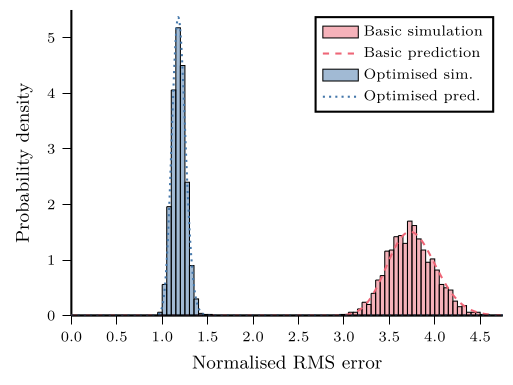

In [4]:
# Histogram of simulated trials of ACES on an instance of lognormal noise compared to predictions for the optimised and basic designs
ls_idx = 2
shot_idx = length(budget_set)
ls_type = ls_types[ls_idx]
@assert ls_type == :wls
noise_name = "lognormal"
# Set plot parameters
x_min = 0.0
x_max = 4.75
x_int = 0.5
bin_int = 0.05
y_min = 0.0
y_max = 5.5
y_int = 1.0
default(grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    legendfonthalign=:left, foreground_color=:black,
    background_color=:transparent, background_color_outside=:transparent,
    tex_output_standalone=true,
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max, xguide="Normalised RMS error",
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max, yguide="Probability density",
    bins=x_min:bin_int:x_max, normalize=:pdf,
)
# Create the plot
opt_colour = colour_series[2]
basic_colour = colour_series[3]
nrmse_hist = plot(; legend=:topright)
histogram!(gate_norm_coll_basic_log[ls_idx, shot_idx]; linewidth=0.5,
    color=basic_colour, normalize=:pdf, label="Basic simulation")
plot!(x_values, nrmse_pdf_coll_basic_log[ls_idx];
    color=basic_colour, linestyle=:dash, label="Basic prediction")
histogram!(gate_norm_coll_log[ls_idx, shot_idx]; linewidth=0.5,
    color=opt_colour, normalize=:pdf, label="Optimised sim.")
plot!(x_values, nrmse_pdf_coll_log[ls_idx];
    color=opt_colour, linestyle=:dot, label="Optimised pred.")
plot!(x_values, zeros(length(x_values)); color=:black, label=nothing)
plot!(size=(col_width_px * 1.028, col_height_px * 1.042))
savefig(nrmse_hist, pwd() * "/figures/nrmse_hist_$(rotated_param.circuit_name)_$(noise_name)_$(ls_type).tex")
display(nrmse_hist)

In [5]:
# Simple figure of merit diagnostics
merit_ratio = (merit_coll_basic_log[2].expectation / merit_coll_log[2].expectation)
sample_ratio = merit_ratio^2
println("The basic design has a figure of merit $(round(merit_ratio, digits=3)) times larger than the optimised design.
This makes the optimised design $(round(sample_ratio, digits=2)) times more sample efficient.")

The basic design has a figure of merit 3.172 times larger than the optimised design.
This makes the optimised design 10.06 times more sample efficient.


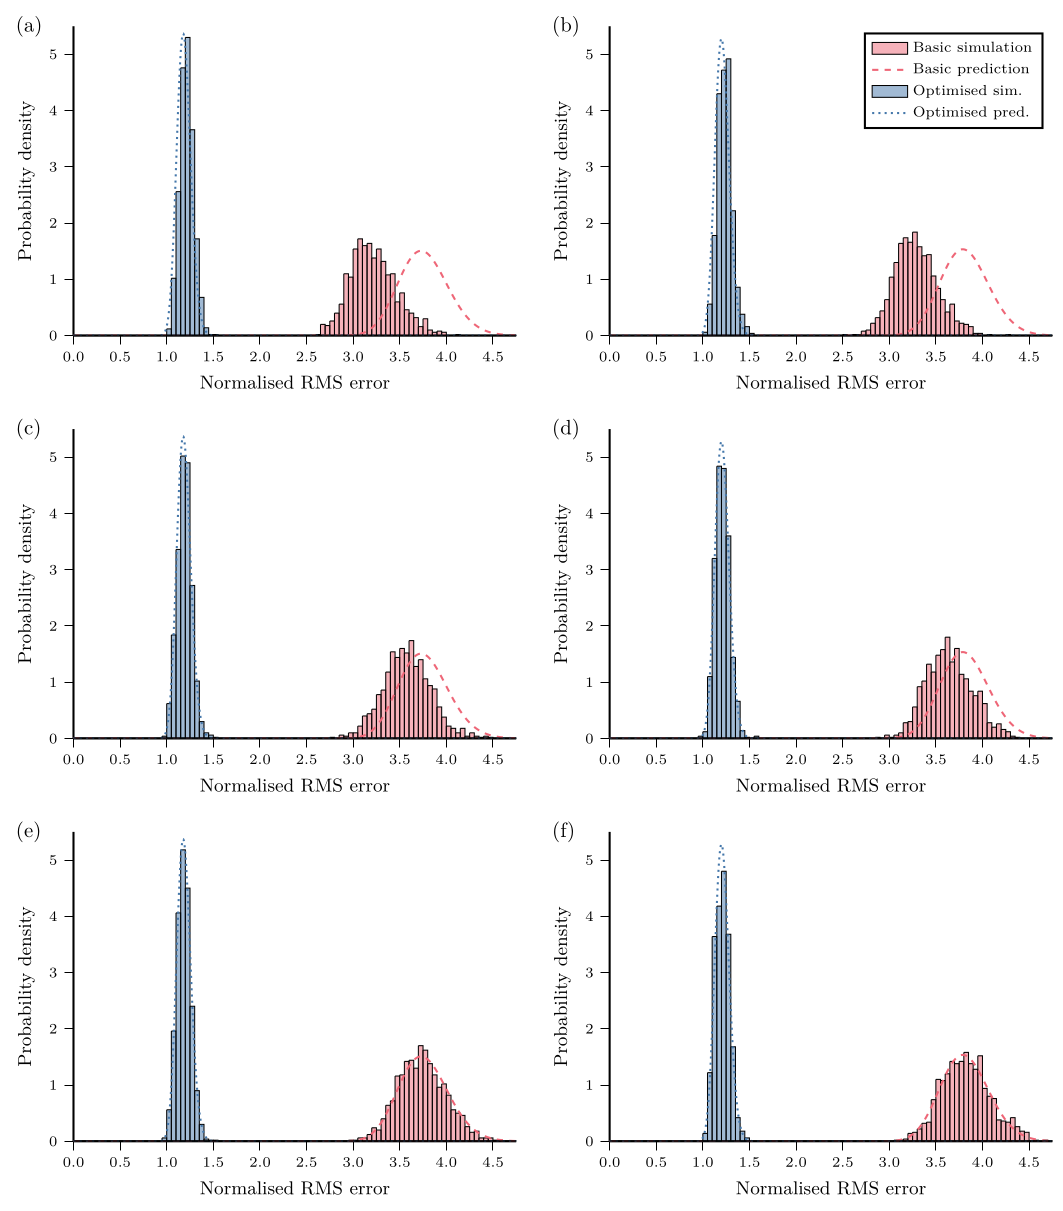

In [6]:
# Histograms of simulated trials of ACES on depolarising noise and an instance of lognormal noise compared to predictions for the optimised and basic designs
# Create all of the histograms
nrmse_plot_set_log = []
nrmse_plot_set_dep = []
ls_idx = 2
ls_type = ls_types[ls_idx]
@assert ls_type == :wls
for shot_idx in eachindex(budget_set)
    # Plot the lognormal noise
    nrmse_subhist_log = plot(; legend=false)
    histogram!(gate_norm_coll_basic_log[ls_idx, shot_idx]; linewidth=0.5,
        color=basic_colour, normalize=:pdf, label="Basic simulation")
    plot!(x_values, nrmse_pdf_coll_basic_log[ls_idx];
        color=basic_colour, linestyle=:dash, label="Basic prediction")
    histogram!(gate_norm_coll_log[ls_idx, shot_idx]; linewidth=0.5,
        color=opt_colour, normalize=:pdf, label="WLS optimised sim.")
    plot!(x_values, nrmse_pdf_coll_log[ls_idx];
        color=opt_colour, linestyle=:dot, label="WLS optimised pred.")
    if shot_idx == 1
        plot!(x_values, zeros(length(x_values)); color=:black, label=nothing,
            extra_kwargs=:plot,
            add=raw"
            \node[anchor=south west] at (0.0-1.1,0.0-0.3) {(a)};
            \node[anchor=south west] at (9.08-1.1,0.0-0.3) {(b)};
            \node[anchor=south west] at (0.0-1.1,-6.82-0.3) {(c)};
            \node[anchor=south west] at (9.08-1.1,-6.82-0.3) {(d)};
            \node[anchor=south west] at (0.0-1.1,-2*6.82-0.3) {(e)};
            \node[anchor=south west] at (9.08-1.1,-2*6.82-0.3) {(f)};
        ")
        # \node at (0.0,0.0) {o};
        # \node at (9.08,0.0) {o};
        # \node at (0.0,-6.82) {o};
        # \node at (9.08,-6.82) {o};
        # \node at (0.0,-2*6.82) {o};
        # \node at (9.08,-2*6.82) {o};
    else
        plot!(x_values, zeros(length(x_values)); color=:black, label=nothing)
    end
    push!(nrmse_plot_set_log, nrmse_subhist_log)
    # Plot the depolarising noise
    if shot_idx == 1
        nrmse_subhist_dep = plot(; legend=:topright)
    else
        nrmse_subhist_dep = plot(; legend=false)
    end
    histogram!(gate_norm_coll_basic_dep[ls_idx, shot_idx]; linewidth=0.5,
        color=basic_colour, normalize=:pdf, label="Basic simulation")
    plot!(x_values, nrmse_pdf_coll_basic_dep[ls_idx];
        color=basic_colour, linestyle=:dash, label="Basic prediction")
    histogram!(gate_norm_coll_dep[ls_idx, shot_idx]; linewidth=0.5,
        color=opt_colour, normalize=:pdf, label="Optimised sim.")
    plot!(x_values, nrmse_pdf_coll_dep[ls_idx];
        color=opt_colour, linestyle=:dot, label="Optimised pred.")
    plot!(x_values, zeros(length(x_values)); color=:black, label=nothing)
    push!(nrmse_plot_set_dep, nrmse_subhist_dep)
end
# Plot the histograms
nrmse_hists = plot(nrmse_plot_set_log[1], nrmse_plot_set_dep[1], nrmse_plot_set_log[2], nrmse_plot_set_dep[2], nrmse_plot_set_log[3], nrmse_plot_set_dep[3]; layout=(3, 2), size=(text_width_px * 1.013, triple_height_px * 1.003))
savefig(nrmse_hists, pwd() * "/figures/nrmse_hists_$(rotated_param.circuit_name)_$(ls_type).tex")
display(nrmse_hists)